In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import zscore
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.ndimage import gaussian_filter1d
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_rows', 10)  
pd.set_option('display.width', 1000)  
pd.set_option('display.colheader_justify', 'left') 

In [3]:
df = pd.read_csv('Data_Collectors/CSV_Files/Ledger_Metadata_2024-11-30.csv')

df = df[['Ledger_Number', 'Row_Count']]

df['Ledger_Number_Scaled'] = (df['Ledger_Number'] // 500)
df['Ledger_Number_Scaled'] -= df['Ledger_Number_Scaled'].min()

df.sort_values(by='Ledger_Number_Scaled')
df.head()

,Ledger_Number,Row_Count,Ledger_Number_Scaled
0,89899995,32,0
1,89900495,27,1
2,89900995,26,2
3,89901495,45,3
4,89901995,31,4


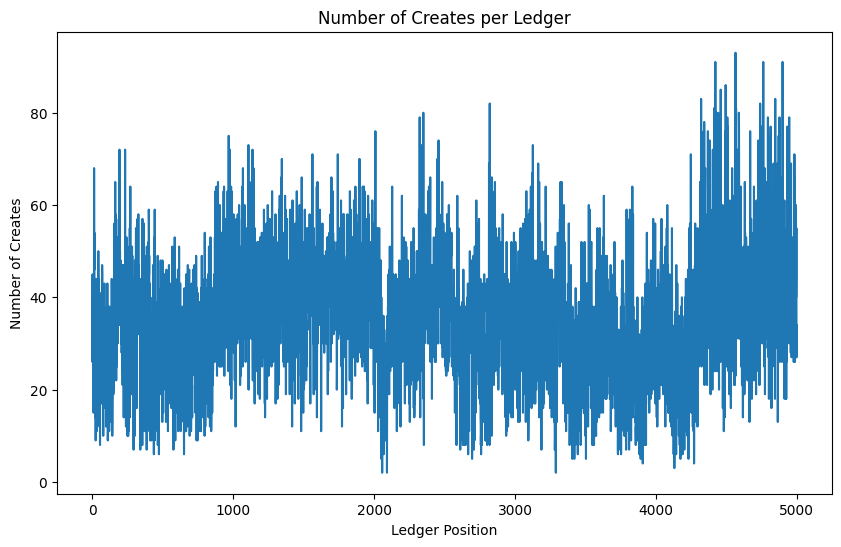

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['Ledger_Number_Scaled'], df['Row_Count'])

plt.xlabel('Ledger Position')
plt.ylabel('Number of Creates')
plt.title('Number of Creates per Ledger')

plt.show()

## No visible relationship any which way, possible high variance
## What about creates related to XRP?

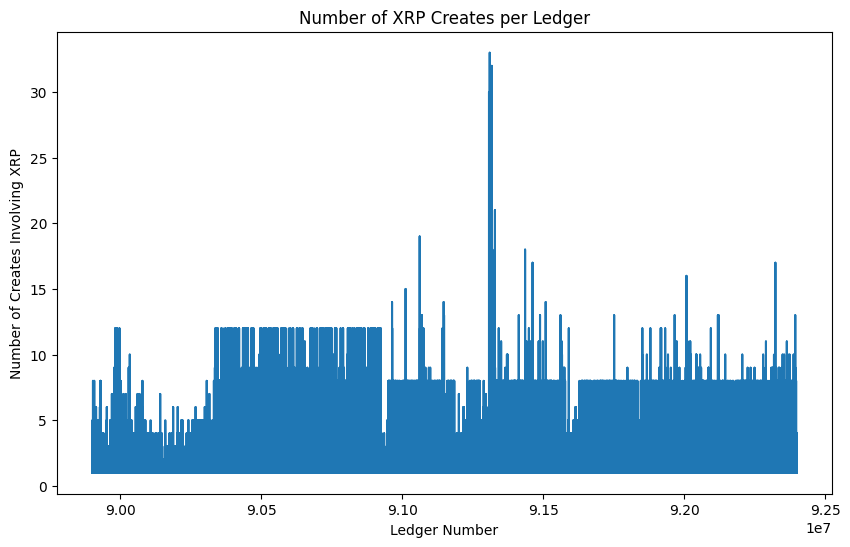

In [5]:
df = pd.read_csv('Data_Collectors/CSV_Files/Ledger_Currency_Pairs_2024-11-30.csv')
df_xrp = df[(df['Gets_Currency_Code'] == 'XRP') | (df['Pays_Currency_Code'] == 'XRP')]
df_xrp_grouped = df_xrp.groupby(['Ledger_Number', 'Ledger_Date']).agg(
    Row_Count=('Row_Count', 'sum')
).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df['Ledger_Number'], df['Row_Count'])

plt.xlabel('Ledger Number')
plt.ylabel('Number of Creates Involving XRP')
plt.title('Number of XRP Creates per Ledger')

plt.show()

## Findings: Once again no visible relationship, could be worth investingating the small section with high outliers
## What about the amount of XRP related in these trades?

In [6]:
# Build transformation function
def transform_row(row):
    if row['Gets_Currency_Code'] == 'XRP':
        return {
            'Ledger_Number': row['Ledger_Number'],
            'Datetime': row['Ledger_Date'],

            'XRP_Code': row['Gets_Currency_Code'],
            'XRP_Amount': row['Gets_Count_sum'],

            'Trade_Code': row['Pays_Currency_Code'],
            'Code_Amount': row['Pays_Count_sum']
        }
    
    elif row['Pays_Currency_Code'] == 'XRP':
        return {
            'Ledger_Number': row['Ledger_Number'],
            'Datetime': row['Ledger_Date'],

            'XRP_Code': row['Pays_Currency_Code'],
            'XRP_Amount': row['Pays_Count_sum'],

            'Trade_Code': row['Gets_Currency_Code'],
            'Code_Amount': row['Gets_Count_sum']
        }
    else:
        print('Error')
        raise ValueError('Invalid row entry')


transformed_data = [transform_row(row) for _, row in df_xrp.iterrows()]
df_xrp = pd.DataFrame(transformed_data)

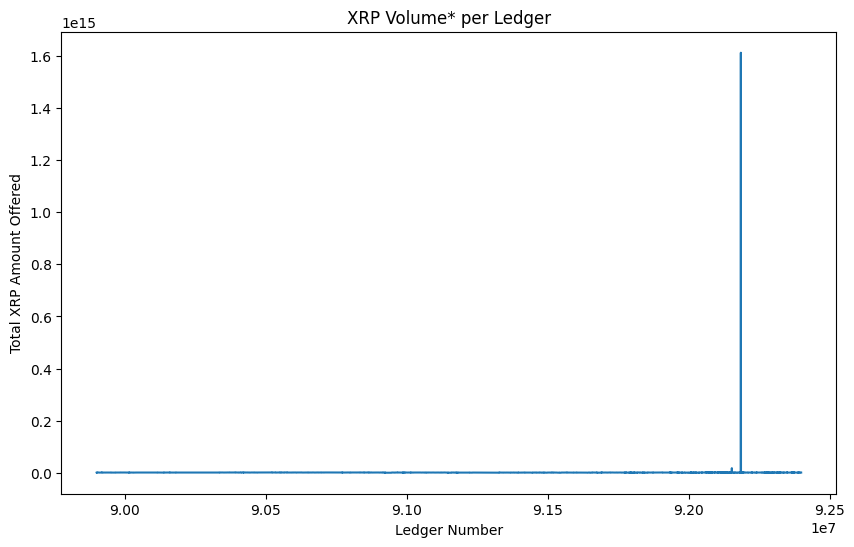

In [7]:
df_xrp_only = df_xrp.groupby(['Ledger_Number', 'Datetime', 'XRP_Code']).agg(
    XRP_Amount=('XRP_Amount', 'sum')
).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_xrp_only['Ledger_Number'], df_xrp_only['XRP_Amount'])

plt.xlabel('Ledger Number')
plt.ylabel('Total XRP Amount Offered')
plt.title('XRP Volume* per Ledger')

plt.show()

### Find and Remove extreme outliers

In [8]:
df_xrp_only['z_score'] = zscore(df_xrp_only['XRP_Amount'], nan_policy='omit')
df_xrp_only.sort_values(by='z_score', ascending=False).head(10)


,Ledger_Number,Datetime,XRP_Code,XRP_Amount,z_score
4554,92185495,2024-11-18T05:17:12.000Z,XRP,1.612689e+15,70.567375
4490,92153495,2024-11-16T18:16:22.000Z,XRP,1.745907e+13,0.720496
4456,92136495,2024-11-15T23:38:50.000Z,XRP,2.354971e+12,0.059165
4835,92325995,2024-11-24T14:42:40.000Z,XRP,2.317040e+12,0.057504
4325,92070995,2024-11-13T00:14:02.000Z,XRP,2.265321e+12,0.055240
4349,92082995,2024-11-13T13:19:52.000Z,XRP,2.230023e+12,0.053694
3566,91691495,2024-10-26T21:39:51.000Z,XRP,2.215662e+12,0.053066
4559,92187995,2024-11-18T08:00:50.000Z,XRP,2.198679e+12,0.052322
4881,92349495,2024-11-25T16:28:20.000Z,XRP,2.133231e+12,0.049456
4409,92112995,2024-11-14T22:00:31.000Z,XRP,2.056149e+12,0.046081


In [9]:
df_xrp_only_cleaned = df_xrp_only[df_xrp_only['z_score'].abs() <=70]
df_xrp_only_cleaned['z_score'] = zscore(df_xrp_only_cleaned['XRP_Amount'], nan_policy='omit')
df_xrp_only_cleaned.sort_values(by='z_score', ascending=False).head(10)

C:\Users\Aymen\AppData\Local\Temp\ipykernel_7492\1907209509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xrp_only_cleaned['z_score'] = zscore(df_xrp_only_cleaned['XRP_Amount'], nan_policy='omit')


,Ledger_Number,Datetime,XRP_Code,XRP_Amount,z_score
4490,92153495,2024-11-16T18:16:22.000Z,XRP,1.745907e+13,46.452750
4456,92136495,2024-11-15T23:38:50.000Z,XRP,2.354971e+12,4.636819
4835,92325995,2024-11-24T14:42:40.000Z,XRP,2.317040e+12,4.531807
4325,92070995,2024-11-13T00:14:02.000Z,XRP,2.265321e+12,4.388622
4349,92082995,2024-11-13T13:19:52.000Z,XRP,2.230023e+12,4.290898
3566,91691495,2024-10-26T21:39:51.000Z,XRP,2.215662e+12,4.251139
4559,92187995,2024-11-18T08:00:50.000Z,XRP,2.198679e+12,4.204123
4881,92349495,2024-11-25T16:28:20.000Z,XRP,2.133231e+12,4.022927
4409,92112995,2024-11-14T22:00:31.000Z,XRP,2.056149e+12,3.809525
4830,92323495,2024-11-24T11:58:32.000Z,XRP,2.046415e+12,3.782577


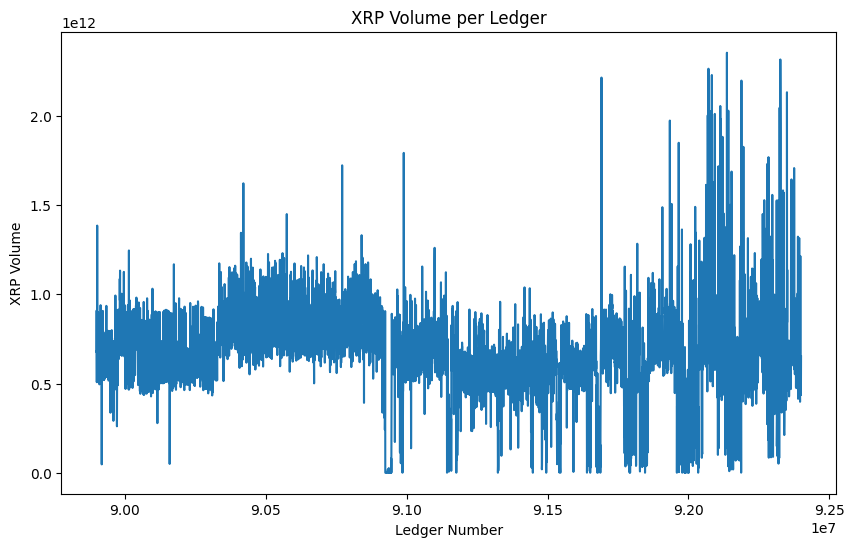

In [10]:
df_xrp_only_cleaned = df_xrp_only_cleaned[df_xrp_only_cleaned['z_score'].abs() <=40]

plt.figure(figsize=(10, 6))
plt.plot(df_xrp_only_cleaned['Ledger_Number'], df_xrp_only_cleaned['XRP_Amount'])

plt.xlabel('Ledger Number')
plt.ylabel('XRP Volume')
plt.title('XRP Volume per Ledger')

plt.show()

## Findings: No visible relationship, maybe an increase in maximums and variance?
## What about XRP trade amounts in relation to other currencies?

In [11]:
df_xrp['XRP_Code_Ratio'] = df_xrp['Code_Amount'] / df_xrp['XRP_Amount']


df_xrp['z_score'] = zscore(df_xrp['XRP_Code_Ratio'], nan_policy='omit')
df_xrp.sort_values(by='z_score', ascending=False).head(10)

,Ledger_Number,Datetime,XRP_Code,XRP_Amount,Trade_Code,Code_Amount,XRP_Code_Ratio,z_score
41411,91997495,2024-11-09T16:30:12.000Z,XRP,1.0,5768617441000000000000000000000000000000,1.000000e+19,1.000000e+19,229.082948
36776,91732995,2024-10-28T18:42:10.000Z,XRP,1.0,4D49494943410000000000000000000000000000,1.000000e+15,1.000000e+15,0.018541
33456,91515995,2024-10-18T23:56:02.000Z,XRP,1.0,5765656200000000000000000000000000000000,1.000000e+15,1.000000e+15,0.018541
35582,91661495,2024-10-25T13:18:21.000Z,XRP,1.0,4772696E64436166C3A900000000000000000000,1.000000e+15,1.000000e+15,0.018541
41091,91970995,2024-11-08T12:07:20.000Z,XRP,1.0,4C617A7900000000000000000000000000000000,1.000000e+15,1.000000e+15,0.018541
33358,91509995,2024-10-18T17:25:10.000Z,XRP,1.0,444F474500000000000000000000000000000000,9.000000e+14,9.000000e+14,0.016250
33450,91515495,2024-10-18T23:23:31.000Z,XRP,1.0,4D41474150455045000000000000000000000000,6.900000e+14,6.900000e+14,0.011439
33085,91494495,2024-10-18T00:31:20.000Z,XRP,1.0,5045495045490000000000000000000000000000,4.296900e+14,4.296900e+14,0.005476
37567,91779495,2024-10-30T20:58:20.000Z,XRP,4.0,5641444552000000000000000000000000000000,4.000000e+14,1.000000e+14,-0.002077
37505,91774495,2024-10-30T15:32:30.000Z,XRP,4.0,ATM,4.000000e+14,1.000000e+14,-0.002077


In [12]:
df_xrp[df_xrp['Trade_Code'] == 'BTC']

,Ledger_Number,Datetime,XRP_Code,XRP_Amount,Trade_Code,Code_Amount,XRP_Code_Ratio,z_score
87,89902495,2024-08-07T19:55:22.000Z,XRP,3.823672e+11,BTC,3.475192,9.088625e-12,-0.004368
98,89902495,2024-08-07T19:55:22.000Z,XRP,3.870820e+05,BTC,0.000004,9.286932e-12,-0.004368
110,89902995,2024-08-07T20:28:00.000Z,XRP,3.421574e+08,BTC,0.002853,8.338267e-12,-0.004368
138,89903495,2024-08-07T21:00:31.000Z,XRP,5.000000e+08,BTC,0.005445,1.089000e-11,-0.004368
159,89903995,2024-08-07T21:33:00.000Z,XRP,1.920718e+10,BTC,0.219504,1.142823e-11,-0.004368
...,...,...,...,...,...,...,...,...
52237,92391995,2024-11-27T15:03:51.000Z,XRP,1.200000e+09,BTC,0.018492,1.541000e-11,-0.004368
52360,92395995,2024-11-27T19:25:21.000Z,XRP,6.748415e+09,BTC,0.104175,1.543696e-11,-0.004368
52388,92396995,2024-11-27T20:31:01.000Z,XRP,6.731078e+09,BTC,0.104175,1.547672e-11,-0.004368
52439,92398495,2024-11-27T22:09:20.000Z,XRP,2.000000e+09,BTC,0.030640,1.532000e-11,-0.004368


In [13]:
# Omitting outliers because looking for trend, don't care for massive price fluctuations
def remove_outliers_by_code(group):
    group['z_score'] = zscore(group['XRP_Code_Ratio'])
    return group[group['z_score'].abs() <= 3]

df_xrp_cleaned = df_xrp.groupby('Trade_Code', group_keys=False).apply(remove_outliers_by_code)
df_xrp_cleaned.sort_values(by='z_score', ascending=False).head(10)


C:\Users\Aymen\AppData\Local\Temp\ipykernel_7492\817653120.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xrp_cleaned = df_xrp.groupby('Trade_Code', group_keys=False).apply(remove_outliers_by_code)


,Ledger_Number,Datetime,XRP_Code,XRP_Amount,Trade_Code,Code_Amount,XRP_Code_Ratio,z_score
6629,90120995,2024-08-17T15:35:41.000Z,XRP,2.470000e+02,SHA,4.283756e+02,1.734314,2.998827
4476,90045495,2024-08-14T06:12:01.000Z,XRP,6.600000e+01,TPR,3.813458e+02,5.777967,2.996527
50747,92345995,2024-11-25T12:37:42.000Z,XRP,5.240490e+06,XUP,6.745647e+08,128.721690,2.989545
51996,92384495,2024-11-27T06:53:40.000Z,XRP,5.240490e+06,XUP,6.744212e+08,128.694300,2.988833
51972,92383495,2024-11-27T05:48:00.000Z,XRP,5.240490e+06,XUP,6.744142e+08,128.692969,2.988799
51742,92375995,2024-11-26T21:33:50.000Z,XRP,5.240490e+06,XUP,6.736072e+08,128.538971,2.984797
52013,92384995,2024-11-27T07:26:12.000Z,XRP,5.240490e+06,XUP,6.735879e+08,128.535288,2.984701
20278,90755995,2024-09-15T01:38:11.000Z,XRP,1.500000e+01,POP,1.000000e+00,0.066667,2.983916
37825,91797995,2024-10-31T17:01:01.000Z,XRP,8.920755e+07,ULT,7.689789e+03,0.000086,2.975295
49289,92299495,2024-11-23T09:47:50.000Z,XRP,1.653340e+10,47414C4100000000000000000000000000000000,8.261455e+05,0.000050,2.966128


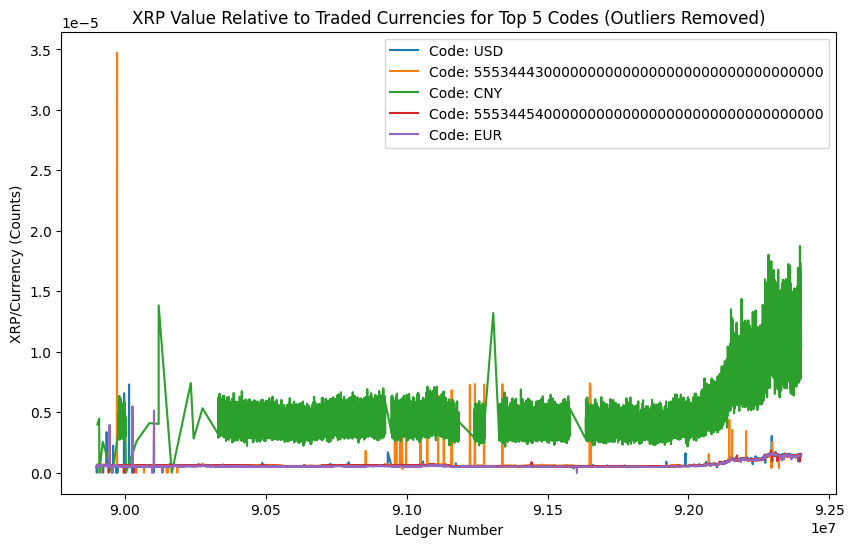

In [14]:
summary = df_xrp_cleaned.groupby('Trade_Code', as_index=False).agg(
    XRP_Sum=('XRP_Amount', 'sum')
)
top_codes = summary.sort_values(by='XRP_Sum', ascending=False).head(5)['Trade_Code']

plt.figure(figsize=(10, 6))

for code in top_codes:
    data = df_xrp_cleaned[df_xrp_cleaned['Trade_Code'] == code]
    plt.plot(data['Ledger_Number'], data['XRP_Code_Ratio'], label=f"Code: {code}")

plt.xlabel('Ledger Number')
plt.ylabel('XRP/Currency (Counts)')
plt.title('XRP Value Relative to Traded Currencies for Top 5 Codes (Outliers Removed)')
plt.legend()

plt.show()


## Apply Loess smoothing

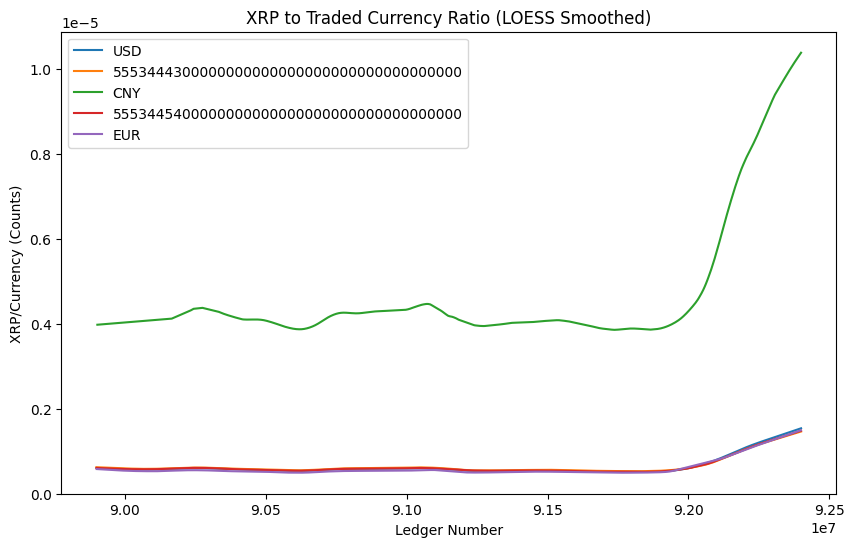

In [15]:
plt.figure(figsize=(10, 6))

for code in top_codes:
    data = df_xrp_cleaned[df_xrp_cleaned['Trade_Code'] == code]
    
    smoothed = lowess(data['XRP_Code_Ratio'], data['Ledger_Number'], frac=0.1)
        
    plt.plot(smoothed[:, 0], smoothed[:, 1], label=f'{code}')

plt.xlabel('Ledger Number')
plt.ylabel('XRP/Currency (Counts)')
plt.title('XRP to Traded Currency Ratio (LOESS Smoothed)')
plt.legend()

plt.show()

## Gaussian Smoothing

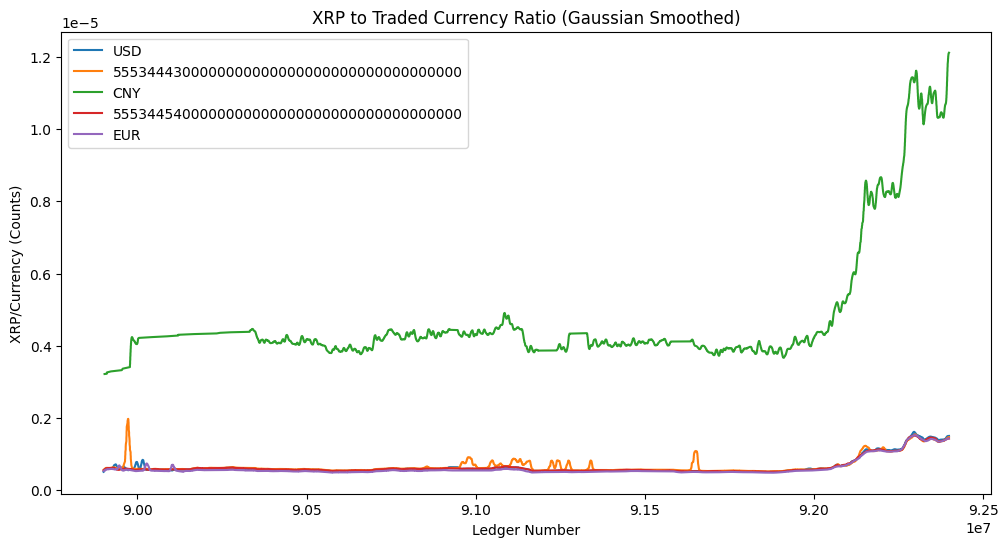

In [16]:
plt.figure(figsize=(12, 6))

for code in top_codes:
    data = df_xrp_cleaned[df_xrp_cleaned['Trade_Code'] == code]

    smoothed = gaussian_filter1d(data['XRP_Code_Ratio'], sigma=10)
        
    plt.plot(data['Ledger_Number'], smoothed, label=f'{code}')

plt.xlabel('Ledger Number')
plt.ylabel('XRP/Currency (Counts)')
plt.title('XRP to Traded Currency Ratio (Gaussian Smoothed)')
plt.legend()

plt.show()


## Plot without CNY to see differences in other currencies

In [17]:
print(top_codes)

308                                         USD
134    5553444300000000000000000000000000000000
233                                         CNY
135    5553445400000000000000000000000000000000
247                                         EUR
Name: Trade_Code, dtype: object


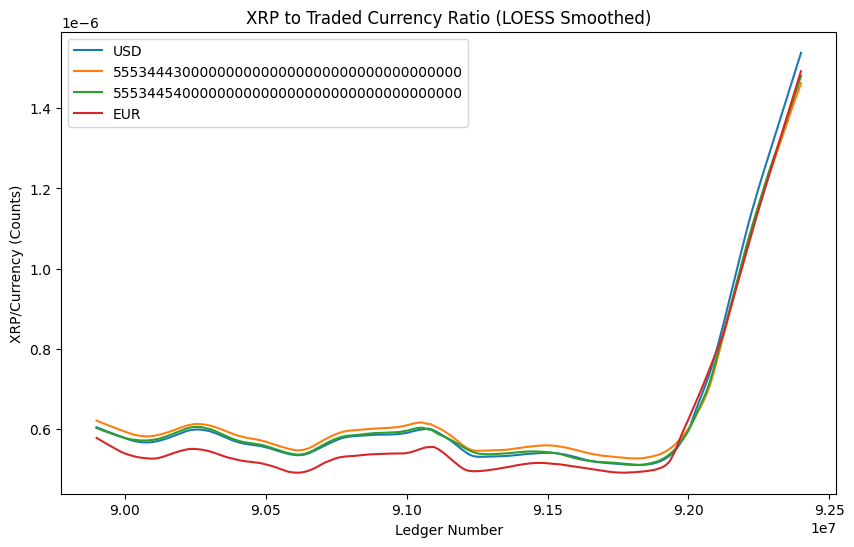

In [18]:
plt.figure(figsize=(10, 6))

top_codes2 = ['USD', '5553444300000000000000000000000000000000', '5553445400000000000000000000000000000000', 'EUR']
for code in top_codes2:
    data = df_xrp_cleaned[df_xrp_cleaned['Trade_Code'] == code]
    
    smoothed = lowess(data['XRP_Code_Ratio'], data['Ledger_Number'], frac=0.1)
        
    plt.plot(smoothed[:, 0], smoothed[:, 1], label=f'{code}')

plt.xlabel('Ledger Number')
plt.ylabel('XRP/Currency (Counts)')
plt.title('XRP to Traded Currency Ratio (LOESS Smoothed)')
plt.legend()

plt.show()

### Results are super similar, Not sure what the large numbers represent as far as currency, but even USD and EUR have surprising parity

## LOESS model provides a smoother/more readable output

## Compare ratio fluctuations with price of currency at the dates of these ledgers

In [19]:
# Find min and max dates for data collection
min_date = df_xrp_cleaned['Datetime'].min()
max_date = df_xrp_cleaned['Datetime'].max()
print(min_date, max_date)

2024-08-07T17:14:31.000Z 2024-11-27T23:14:50.000Z


## Data for these dates has been collected using the xrpPriceCollector.py
## Join price data for comparison:

In [20]:
df_ratio = df_xrp_cleaned[df_xrp_cleaned['Trade_Code'] == 'USD']
df_price = pd.read_csv('Data_Collectors/CSV_Files/XRP_Prices_2024-11-30.csv')

In [21]:
df_ratio['Datetime'] = pd.to_datetime(df_ratio['Datetime'], utc=True)
df_price['TimeStamp'] = pd.to_datetime(df_price['TimeStamp'], utc=True)

df_ratio['Datetime_Rounded'] = df_ratio['Datetime'].dt.round('H')
df_price['TimeStamp_Rounded'] = df_price['TimeStamp'].dt.round('H')

df_ratio['Trade_Code'] = df_ratio['Trade_Code'].str.lower()
df_price['Currency'] = df_price['Currency'].str.lower()

df_result = pd.merge(
    df_ratio,
    df_price[['TimeStamp_Rounded', 'Price', 'Currency']],
    left_on=['Datetime_Rounded', 'Trade_Code'],
    right_on=['TimeStamp_Rounded', 'Currency'],
    how='left'
)

df_result.drop(columns=['Datetime_Rounded', 'z_score', 'XRP_Code_Ratio', 'TimeStamp_Rounded', 'Currency'], inplace=True)


df_result['Ratio'] = df_result['Code_Amount'] / df_result['XRP_Amount']

C:\Users\Aymen\AppData\Local\Temp\ipykernel_7492\2381344439.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ratio['Datetime'] = pd.to_datetime(df_ratio['Datetime'], utc=True)
C:\Users\Aymen\AppData\Local\Temp\ipykernel_7492\2381344439.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_ratio['Datetime_Rounded'] = df_ratio['Datetime'].dt.round('H')
C:\Users\Aymen\AppData\Local\Temp\ipykernel_7492\2381344439.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

## Eliminate Outliers

In [22]:
df_result['z_score'] = zscore(df_result['Ratio'], nan_policy='omit')
df_result.sort_values(by='z_score', ascending=False).head(10)

,Ledger_Number,Datetime,XRP_Code,XRP_Amount,Trade_Code,Code_Amount,Price,Ratio,z_score
339,90015495,2024-08-12 21:40:30+00:00,XRP,1.000000e+00,usd,0.000007,0.565409,0.000007,26.030472
286,89997995,2024-08-12 02:43:11+00:00,XRP,1.000000e+00,usd,0.000007,0.560470,0.000007,23.179097
113,89935995,2024-08-09 08:02:10+00:00,XRP,1.000000e+00,usd,0.000003,0.602647,0.000003,10.622749
6891,92295495,2024-11-23 05:26:40+00:00,XRP,9.441850e+09,usd,28617.139410,1.525887,0.000003,9.345868
178,89958995,2024-08-10 08:53:21+00:00,XRP,1.000000e+00,usd,0.000002,0.587380,0.000002,6.254526
6933,92308995,2024-11-23 20:10:32+00:00,XRP,6.850701e+10,usd,117565.143243,1.462937,0.000002,4.207547
3230,90933495,2024-09-23 00:20:01+00:00,XRP,1.827257e+10,usd,30898.914990,0.587519,0.000002,4.109437
6879,92290995,2024-11-23 00:31:31+00:00,XRP,4.721338e+10,usd,78259.045322,1.597357,0.000002,3.978752
6887,92293995,2024-11-23 03:48:30+00:00,XRP,2.927800e+10,usd,48295.817680,1.544979,0.000002,3.947485
6881,92291495,2024-11-23 01:04:32+00:00,XRP,2.695681e+11,usd,440244.342962,1.597357,0.000002,3.883341


In [23]:
df_result = df_result[df_result['z_score'].abs() <= 7]
df_result['z_score'] = zscore(df_result['Ratio'], nan_policy='omit')
pd.set_option('display.max_rows', 30)
df_result.sort_values(by='z_score', ascending=False).head(30)

,Ledger_Number,Datetime,XRP_Code,XRP_Amount,Trade_Code,Code_Amount,Price,Ratio,z_score
178,89958995,2024-08-10 08:53:21+00:00,XRP,1.000000e+00,usd,0.000002,0.587380,0.000002,6.988422
6933,92308995,2024-11-23 20:10:32+00:00,XRP,6.850701e+10,usd,117565.143243,1.462937,0.000002,4.704770
3230,90933495,2024-09-23 00:20:01+00:00,XRP,1.827257e+10,usd,30898.914990,0.587519,0.000002,4.595317
6879,92290995,2024-11-23 00:31:31+00:00,XRP,4.721338e+10,usd,78259.045322,1.597357,0.000002,4.449522
6887,92293995,2024-11-23 03:48:30+00:00,XRP,2.927800e+10,usd,48295.817680,1.544979,0.000002,4.414640
6881,92291495,2024-11-23 01:04:32+00:00,XRP,2.695681e+11,usd,440244.342962,1.597357,0.000002,4.343079
6918,92304495,2024-11-23 15:14:50+00:00,XRP,8.516800e+10,usd,138905.105602,1.562576,0.000002,4.333518
6892,92295995,2024-11-23 05:59:30+00:00,XRP,2.931900e+10,usd,47555.711190,1.543598,0.000002,4.294522
6893,92296495,2024-11-23 06:32:10+00:00,XRP,3.052100e+10,usd,49478.813940,1.550438,0.000002,4.290729
6900,92298495,2024-11-23 08:42:40+00:00,XRP,6.104200e+10,usd,98883.690757,1.559451,0.000002,4.285448


## Scale Data due to large ratio discrepancy with price

In [24]:
df_result['Price_Scaled'] = (df_result['Price'] - df_result['Price'].min()) / (df_result['Price'].max() - df_result['Price'].min())
df_result['Ratio_Scaled'] = (df_result['Ratio'] - df_result['Ratio'].min()) / (df_result['Ratio'].max() - df_result['Ratio'].min())

print(df_result.head())

   Ledger_Number Datetime                  XRP_Code  XRP_Amount   Trade_Code  Code_Amount    Price     Ratio         z_score   Price_Scaled  Ratio_Scaled
0  89899995      2024-08-07 17:14:31+00:00  XRP      2.000000e+11  usd         97638.000000  0.503431  4.881900e-07 -0.648917  0.007231      0.217768    
1  89899995      2024-08-07 17:14:31+00:00  XRP      2.000000e+11  usd         97638.000000  0.504509  4.881900e-07 -0.648917  0.008209      0.217768    
2  89899995      2024-08-07 17:14:31+00:00  XRP      2.000000e+11  usd         97638.000000  0.504509  4.881900e-07 -0.648917  0.008209      0.217768    
3  89900495      2024-08-07 17:46:40+00:00  XRP      4.000000e+11  usd        195709.505200  0.502315  4.892738e-07 -0.644191  0.006218      0.218252    
4  89900495      2024-08-07 17:46:40+00:00  XRP      7.299190e+10  usd         38015.491734  0.502315  5.208179e-07 -0.506659  0.006218      0.232339    



## Compare fluctuations

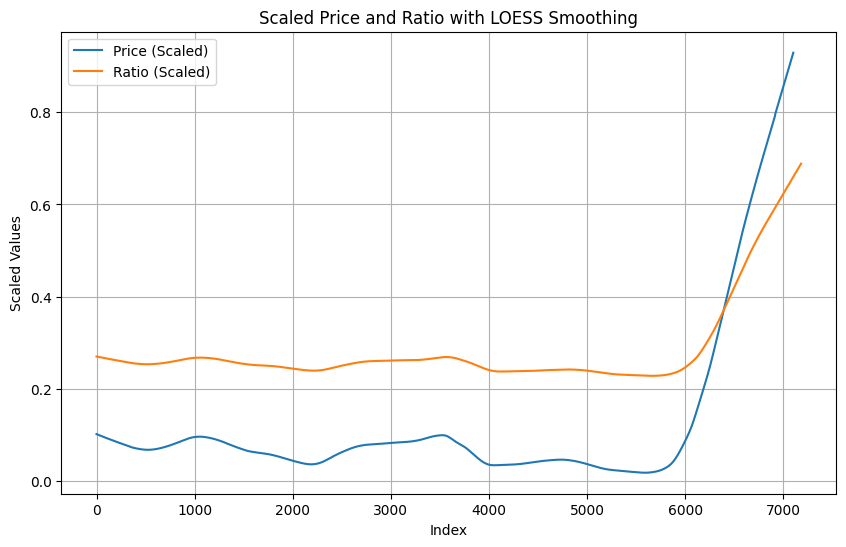

In [25]:
price_smooth = lowess(df_result['Price_Scaled'], np.arange(len(df_result)), frac=0.1)[:, 1]
ratio_smooth = lowess(df_result['Ratio_Scaled'], np.arange(len(df_result)), frac=0.1)[:, 1]

plt.figure(figsize=(10, 6))

plt.plot(price_smooth, label='Price (Scaled)')
plt.plot(ratio_smooth, label='Ratio (Scaled)')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Scaled Values')
plt.title('Scaled Price and Ratio with LOESS Smoothing')
plt.legend()
plt.grid(True)
plt.show()

## Remove more outliers to get better graph?

In [26]:
df_result = df_result[df_result['z_score'].abs() <= 3]
df_result['z_score'] = zscore(df_result['Ratio'], nan_policy='omit')
df_result.sort_values(by='z_score', ascending=False).head(10)

,Ledger_Number,Datetime,XRP_Code,XRP_Amount,Trade_Code,Code_Amount,Price,Ratio,z_score,Price_Scaled,Ratio_Scaled
6826,92269495,2024-11-22 00:58:12+00:00,XRP,6.980800e+10,usd,92473.434341,1.289517,0.000001,5.331783,0.720626,0.591311
6845,92275995,2024-11-22 08:06:11+00:00,XRP,2.032790e+11,usd,269092.326100,1.370153,0.000001,5.325031,0.793806,0.590899
7079,92365495,2024-11-26 10:01:30+00:00,XRP,6.243069e+09,usd,8250.759619,1.376698,0.000001,5.309162,0.799745,0.589929
7120,92378995,2024-11-27 00:51:30+00:00,XRP,2.000000e+11,usd,264314.000000,1.370205,0.000001,5.309036,0.793852,0.589921
7130,92381995,2024-11-27 04:09:10+00:00,XRP,2.000000e+11,usd,264286.000000,1.364259,0.000001,5.308013,0.788457,0.589859
6832,92271495,2024-11-22 03:10:11+00:00,XRP,2.000000e+11,usd,264240.000000,1.360792,0.000001,5.306332,0.785310,0.589756
7086,92367495,2024-11-26 12:13:31+00:00,XRP,2.000000e+11,usd,264132.198000,1.329055,0.000001,5.302393,0.756508,0.589515
6824,92268995,2024-11-22 00:25:10+00:00,XRP,8.450038e+10,usd,111407.506428,1.241637,0.000001,5.286059,0.677173,0.588517
7082,92366495,2024-11-26 11:07:20+00:00,XRP,2.088183e+11,usd,275013.671155,1.323932,0.000001,5.275635,0.751858,0.587880
6829,92270495,2024-11-22 02:04:20+00:00,XRP,2.000000e+11,usd,262366.000000,1.373557,0.000001,5.237853,0.796895,0.585572


In [27]:
df_result['Price_Scaled'] = (df_result['Price'] - df_result['Price'].min()) / (df_result['Price'].max() - df_result['Price'].min())
df_result['Ratio_Scaled'] = (df_result['Ratio'] - df_result['Ratio'].min()) / (df_result['Ratio'].max() - df_result['Ratio'].min())

print(df_result.head())

   Ledger_Number Datetime                  XRP_Code  XRP_Amount   Trade_Code  Code_Amount    Price     Ratio         z_score   Price_Scaled  Ratio_Scaled
0  89899995      2024-08-07 17:14:31+00:00  XRP      2.000000e+11  usd         97638.000000  0.503431  4.881900e-07 -0.781627  0.008513      0.368280    
1  89899995      2024-08-07 17:14:31+00:00  XRP      2.000000e+11  usd         97638.000000  0.504509  4.881900e-07 -0.781627  0.009664      0.368280    
2  89899995      2024-08-07 17:14:31+00:00  XRP      2.000000e+11  usd         97638.000000  0.504509  4.881900e-07 -0.781627  0.009664      0.368280    
3  89900495      2024-08-07 17:46:40+00:00  XRP      4.000000e+11  usd        195709.505200  0.502315  4.892738e-07 -0.773707  0.007320      0.369099    
4  89900495      2024-08-07 17:46:40+00:00  XRP      7.299190e+10  usd         38015.491734  0.502315  5.208179e-07 -0.543170  0.007320      0.392921    


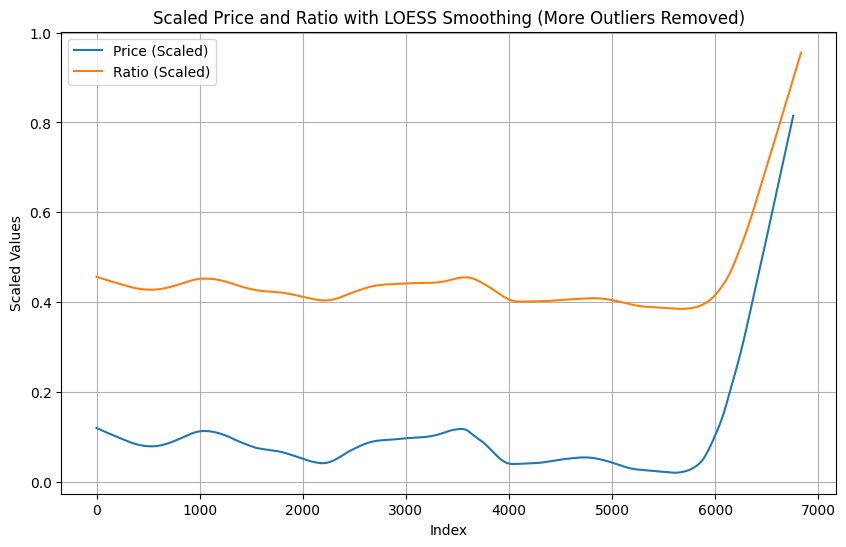

In [28]:
price_smooth = lowess(df_result['Price_Scaled'], np.arange(len(df_result)), frac=0.1)[:, 1]
ratio_smooth = lowess(df_result['Ratio_Scaled'], np.arange(len(df_result)), frac=0.1)[:, 1]

plt.figure(figsize=(10, 6))

plt.plot(price_smooth, label='Price (Scaled)')
plt.plot(ratio_smooth, label='Ratio (Scaled)')

plt.xlabel('Index')
plt.ylabel('Scaled Values')
plt.title('Scaled Price and Ratio with LOESS Smoothing (More Outliers Removed)')
plt.legend()
plt.grid(True)
plt.show()

## The scaled data looks good, but why is the unscaled data so different? Might be a difference in how XRP or USD is calculated, something like Gwei vs Ether?